In [1]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import fiona
from rasterio.warp import reproject, Resampling
from rasterio.mask import mask
from rasterio.plot import show
%matplotlib inline

In [2]:
dem_src = rasterio.open("/home/cparr/surfaces/level_1_surfaces/hv/bare_earth/hv_dem_filtered.tif")
dem_src.meta

{'count': 1,
 'crs': CRS({'init': 'epsg:32606'}),
 'driver': 'GTiff',
 'dtype': 'float32',
 'height': 11360,
 'nodata': nan,
 'transform': Affine(1.0, 0.0, 421845.75,
       0.0, -1.0, 7673711.25),
 'width': 2340}

In [3]:
src_2012 = rasterio.open("/home/cparr/surfaces/level_1_surfaces/hv/hv_2012_107_snow_on_dem.tif")
src_2012.meta

{'count': 1,
 'crs': CRS({'init': 'epsg:32606'}),
 'driver': 'GTiff',
 'dtype': 'float32',
 'height': 5680,
 'nodata': -9999.0,
 'transform': Affine(2.0, 0.0, 421844.8544921875,
       0.0, -2.0, 7673710.457519531),
 'width': 1169}

In [4]:
# Crop the 2013 data

with fiona.open("/home/cparr/surfaces/level_1_surfaces/hv/bare_earth/hv_2012_158_clipper.shp", "r") as shapefile:
    geoms = [feature["geometry"] for feature in shapefile]

out_image, out_transform = mask(src_2012, geoms, crop=True)
out_meta = src_2012.meta.copy()

out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2]+1,
                 "transform": out_transform})

# Replace -32767 NoData value with np.nan

out_image.data[out_image.data == -9999.0] = np.nan
out_meta.update({"nodata": np.nan})

# Write the cropped version out to a new raster

with rasterio.open("/home/cparr/surfaces/level_1_surfaces/hv/hv_2012_107_crop.tif", "w", **out_meta) as dest:
    dest.write(out_image)
    
del out_image
del out_transform
del src_2012

# Read the cropped raster back in

src_2012 = rasterio.open("/home/cparr/surfaces/level_1_surfaces/hv/hv_2012_107_crop.tif")
src_2012.meta

{'count': 1,
 'crs': CRS({'init': 'epsg:32606'}),
 'driver': 'GTiff',
 'dtype': 'float32',
 'height': 5680,
 'nodata': nan,
 'transform': Affine(2.0, 0.0, 421844.8544921875,
       0.0, -2.0, 7673710.457519531),
 'width': 1170}

In [5]:
# Upsample the 2012 data to 1 m 

src_2012_arr = src_2012.read(1)

new_2012_arr = np.empty(shape=(
                            round(src_2012_arr.shape[0] * 2),
                            round(src_2012_arr.shape[1] * 2)))

aff12 = src_2012.transform
newaff12 = rasterio.Affine(aff12.a / 2.0, aff12.b, aff12.c,
                          aff12.d, aff12.e / 2.0, aff12.f)

reproject(
    src_2012_arr, new_2012_arr,
    src_transform = aff12,
    dst_transform = newaff12,
    src_crs = src_2012.crs,
    dst_crs = src_2012.crs,
    resample = Resampling.bilinear)

del src_2012_arr

print (new_2012_arr.shape, new_2012_arr.size)
print (np.nanmin(new_2012_arr))
print (np.nanmax(new_2012_arr))

(11360, 2340) 26582400
345.826385498
433.141662598


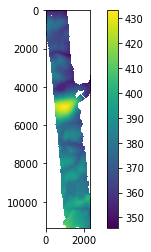

In [6]:
plt.imshow(new_2012_arr)
plt.colorbar()

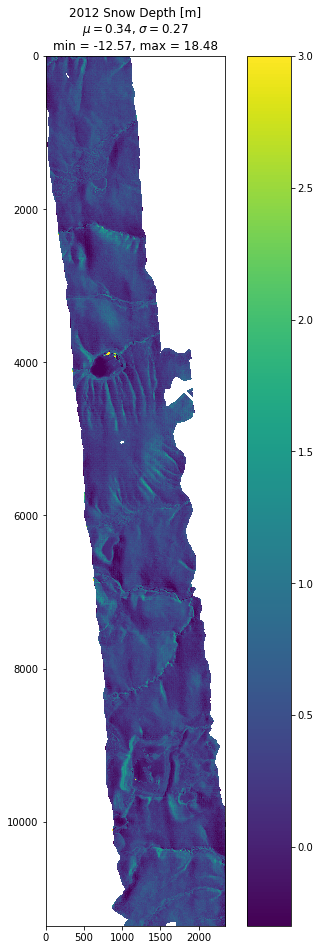

In [7]:
# Create the difference (snow depth) map

delta = new_2012_arr - dem_src.read(1)
mu = np.nanmean(delta)
sigma = np.nanstd(delta)
dmin = np.nanmin(delta)
dmax = np.nanmax(delta)


fig = plt.figure(figsize = (8,16))
ax = fig.add_subplot(111)
im = ax.imshow(delta,vmin=-0.3,vmax=3)
ax.set_title("2012 Snow Depth [m]" +'\n'+
             "$\mu=%.2f$, $\sigma=%.2f$"  %(mu,sigma)  +'\n'+
             "min = %.2f, max = %.2f" %(dmin,dmax))
fig.colorbar(im)

Not a bad result. It looks like the artefacts mostly have really high values on the lakes, which is pretty typical for this type of technique. If you look closely you can also see the outline of the 2012 bare earth DEM causing some higher than normal values. We can try to filter these out. Judging by the minimum, there are also some very low negative values. We can filter those as well.

/home/cparr/miniconda3/envs/raster_IO_pd/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.
/home/cparr/miniconda3/envs/raster_IO_pd/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  


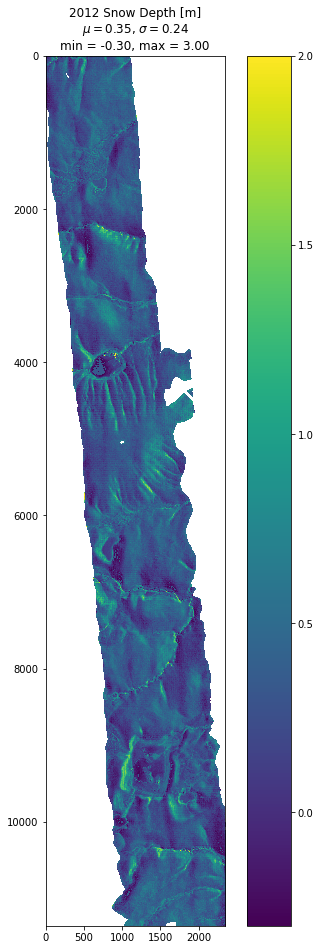

In [8]:
delta[delta > 3.0] = np.nanmean(delta)
delta[delta < -0.3] = np.nanmean(delta)
delta = delta.astype('float32')

mu = np.nanmean(delta)
sigma = np.nanstd(delta)
dmin = np.nanmin(delta)
dmax = np.nanmax(delta)


fig = plt.figure(figsize = (8,16))
ax = fig.add_subplot(111)
im = ax.imshow(delta,vmin=-0.3,vmax=2)
ax.set_title("2012 Snow Depth [m]" +'\n'+
             "$\mu=%.2f$, $\sigma=%.2f$"  %(mu,sigma)  +'\n'+
             "min = %.2f, max = %.2f" %(dmin,dmax))
fig.colorbar(im)

This seems pretty good for now. I'd be hesitant to clip any further. I could remove all negative values and replace them with the mean (or with zero) but they seem to be pretty isolated on the lakes at the moment.

In [9]:
out_meta = src_2012.meta.copy()

out_meta.update({"height": delta.shape[0],
                 "width": delta.shape[1],
                 "transform": newaff12})

out_meta

{'count': 1,
 'crs': CRS({'init': 'epsg:32606'}),
 'driver': 'GTiff',
 'dtype': 'float32',
 'height': 11360,
 'nodata': nan,
 'transform': Affine(1.0, 0.0, 421844.8544921875,
       0.0, -1.0, 7673710.457519531),
 'width': 2340}

In [10]:
with rasterio.open("/home/cparr/surfaces/depth_ddems/hv_version3/hv_depth_107_2012.tif", "w", **out_meta) as dest:
    dest.write(delta,1)

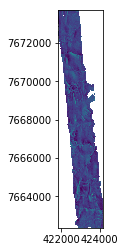

In [11]:
src = rasterio.open("/home/cparr/surfaces/depth_ddems/hv_version3/hv_depth_107_2012.tif")
show(src)